<a href="https://colab.research.google.com/github/Apekshagaonkar/dl_covid/blob/main/2.Training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [3]:
%cd "/content/drive/My Drive/Covid19AI"

/content/drive/My Drive/Covid19AI


In [4]:
import glob, numpy as np, cv2, matplotlib.pyplot as plt, copy, tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import Model, callbacks as cb, optimizers
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Lambda, Input, Conv2D, Conv2DTranspose, concatenate, MaxPooling2D
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from skimage.filters import rank
from skimage.morphology import disk

from BEASF import BEASF
#from visualization_tools import GradCAM

num covid images: 100
num non_covid images: 200
number of total dataset images: 300
number of total dataset labels: 300
dataset shape: (300, 320, 320, 3)


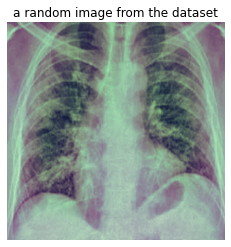

In [13]:
X = np.load(file='/content/drive/My Drive/Covid19AI/covid_cxr_dataset/train_cxr_segmented.npy')
y = np.load(file='/content/drive/My Drive/Covid19AI/covid_cxr_dataset/train_cxr_ylabel.npy')

num_covid_samples = 0
num_non_covid_samples = 0
for idx, img in enumerate(X):
  if y[idx]==2:
    num_covid_samples += 1
  else:
    num_non_covid_samples += 1
print('num covid images:', num_covid_samples)
print('num non_covid images:', num_non_covid_samples)


# manual label smoothing by 0.1 deviation
# y[np.where(y == 0)] = 0.1
# y[np.where(y == 1)] = 0.9

# apply image enhancements and concat with the original image
X_beasf = np.array([BEASF(image=image, gamma=1.5) for image in X])
X_clahe = np.array([cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(image) for image in X])
X_clahe = np.array([np.expand_dims(a=image, axis=-1) for image in X_clahe])
X = np.concatenate((X_beasf, X_clahe, X), axis=-1)

X = np.array([X[idx] / 255. for idx in range(len(X))])

print('number of total dataset images:', len(X))
print('number of total dataset labels:', len(y))
print('dataset shape:', X.shape)

rnd_idx = np.random.choice(a=len(X), size=None)
plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
plt.axis('off')
plt.title(label='a random image from the dataset')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

# # NOTE: sklearn train_test_split function copies the dataset, hence deleting initial data
# # variables will increase RAM space drastically (~ x2)
del X

In [14]:
# IMPORTANT: applying zoom and brightness at the same time will change image pixel range from
# [0, 1] to [0, 255], hence we need to add rescaling again (despite doing it when importing
# dataset). Otherwise, model will see all validation data (not undergone augmentation) as 
# black images giving a same prediction value for all
augmenter = ImageDataGenerator(rotation_range=170, horizontal_flip=True, vertical_flip=True, 
                               zoom_range=[0.8, 1.5], brightness_range=[0.5, 1.3], rescale=1./255,
                               width_shift_range=0.2, height_shift_range=0.2, fill_mode='constant')

# NOTE: Keras ImageDataGenerator does not keep input image default ratio (as of v2.3.1)
# NOTE: Keras ImageDataGenerator does not resize-and-padd when doing rotation (thus 
# loosing part of the image due to cropping while rotating)
checkpoint = cb.ModelCheckpoint('/content/drive/My Drive/covid_model/eps={epoch:03d}_valLoss={val_loss:.4f}.hdf5',
                                monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cb_list = [checkpoint]

In [15]:
X_test = np.array([X_test[idx] / 255. for idx in range(len(X_test))])

In [16]:
backbone = load_model("/content/drive/My Drive/Covid19AI/Pretrained_Model/CheXNet_model.hdf5")
fc = Dense(units=10, activation='relu', name='fc')(backbone.layers[-2].output)
do = Dropout(rate=0.2, name='dropout')(fc)
output = Dense(units=1, activation='softmax', name='pred')(do)
classifier = Model(inputs=backbone.input, outputs=output)
classifier.trainable = True

fast_adam = optimizers.Adam(learning_rate=0.0001)
smoothened_cce = tf.losses.CategoricalCrossentropy(label_smoothing=0.1)
classifier.compile(optimizer=fast_adam, loss=smoothened_cce, metrics=['accuracy'])
#classifier.summary()
print('num pretrained network layers:', len(classifier.layers))
#del backbone

num pretrained network layers: 431


In [9]:
!pip3 install keras_lr_finder

In [17]:
from keras_lr_finder.lr_finder import LRFinder
lr_finder = LRFinder(model=classifier)
lr_finder.find(x_train=X_train, y_train=y_train, start_lr=0.0000001, end_lr=0.1, batch_size=5, epochs=10)
# best lr is where the plot has highest decreasing slope before the loss jump
#lr_finder.plot_loss()
# lr_finder.plot_loss_change(sma=5, n_skip_beginning=5, n_skip_end=5, y_lim=(-0.05, 0.05))

Epoch 1/10
48/48 [==============================] - 15s 112ms/step - loss: 0.0000e+00 - accuracy: 0.3163
Epoch 2/10
48/48 [==============================] - 5s 112ms/step - loss: 0.0000e+00 - accuracy: 0.3478
Epoch 3/10
48/48 [==============================] - 5s 112ms/step - loss: 0.0000e+00 - accuracy: 0.2563
Epoch 4/10
48/48 [==============================] - 5s 113ms/step - loss: 0.0000e+00 - accuracy: 0.3086
Epoch 5/10
48/48 [==============================] - 5s 113ms/step - loss: 0.0000e+00 - accuracy: 0.2840
Epoch 6/10
48/48 [==============================] - 5s 113ms/step - loss: 0.0000e+00 - accuracy: 0.2944
Epoch 7/10
48/48 [==============================] - 5s 113ms/step - loss: 0.0000e+00 - accuracy: 0.3376
Epoch 8/10
48/48 [==============================] - 5s 114ms/step - loss: 0.0000e+00 - accuracy: 0.2991
Epoch 9/10
48/48 [==============================] - 5s 113ms/step - loss: 0.0000e+00 - accuracy: 0.3439
Epoch 10/10
48/48 [==============================] - 5s 113ms/s

class weights are: [1. 1. 1.]
Epoch 1/20
15/15 [==============================] - 21s 806ms/step - loss: 0.0000e+00 - accuracy: 0.3208 - val_loss: 0.0000e+00 - val_accuracy: 0.3833

Epoch 00001: val_loss improved from inf to 0.00000, saving model to /content/drive/My Drive/covid_model/eps=001_valLoss=0.0000.hdf5
Epoch 2/20
15/15 [==============================] - 7s 475ms/step - loss: 0.0000e+00 - accuracy: 0.3208 - val_loss: 0.0000e+00 - val_accuracy: 0.3833

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/20
15/15 [==============================] - 7s 484ms/step - loss: 0.0000e+00 - accuracy: 0.3208 - val_loss: 0.0000e+00 - val_accuracy: 0.3833

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/20
15/15 [==============================] - 7s 481ms/step - loss: 0.0000e+00 - accuracy: 0.3208 - val_loss: 0.0000e+00 - val_accuracy: 0.3833

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/20
15/15 [==============================] - 7s 481ms/step - loss: 0.0000

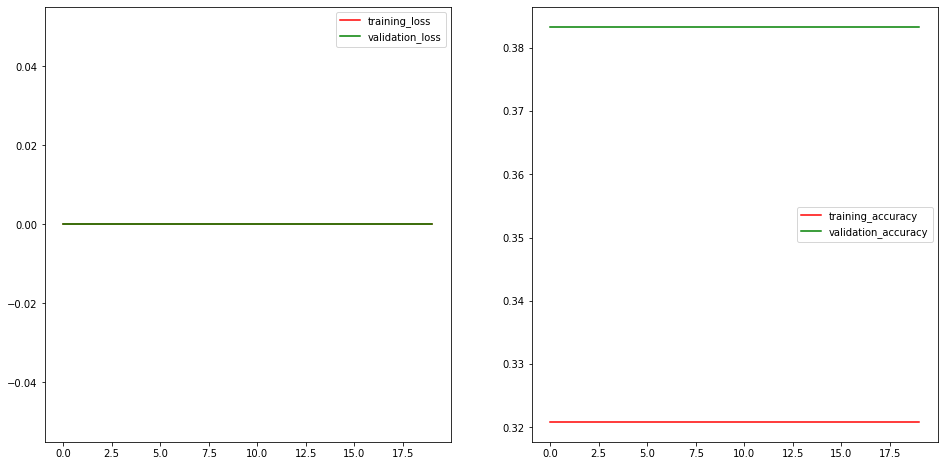

In [18]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(y), y=y).astype('float32')
print('class weights are:', class_weights)
fine_tuning = classifier.fit(augmenter.flow(x=X_train, y=y_train, batch_size=16), 
                             steps_per_epoch=len(X_train)//16,
                             callbacks=cb_list, epochs=20, verbose=1, 
                             validation_data=(X_test, y_test),
                             class_weight=dict({0: class_weights[0], 1: class_weights[1], 
                                                2: class_weights[2]}))

fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(fine_tuning.history['loss'], color='r', label='training_loss')
plt.plot(fine_tuning.history['val_loss'], color='g', label='validation_loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(fine_tuning.history['accuracy'], color='r', label='training_accuracy')
plt.plot(fine_tuning.history['val_accuracy'], color='g', label='validation_accuracy')
plt.legend()
plt.show()
# fig.savefig('/content/drive/My Drive/covid_model/fine_tuning.png')